# Table of Contents
* [Load datasets](#Load-datasets)
	* [ADE20K](#ADE20K)
	* [PASCAL](#PASCAL)
	* [COCO](#COCO)
* [Response of objects to forces](#Response-of-objects-to-forces)
	* [Dynamics](#Dynamics)
	* [Statics](#Statics)
* [Spatial relationships between objects within a scene](#Spatial-relationships-between-objects-within-a-scene)
	* [Kinematics (geometry of motion)](#Kinematics-%28geometry-of-motion%29)
		* [Trajectories](#Trajectories)
		* [Collisions](#Collisions)
	* [Topology](#Topology)
	* [Geometry](#Geometry)
		* [Metrics](#Metrics)
		* [Symmetry](#Symmetry)
* [Affordances](#Affordances)


In [7]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [8]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [9]:
import scipy.io as sio
import glob
import xmltodict
import PIL.Image as Image
from pycocotools.coco import COCO
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [10]:
import os

# Load datasets

## ADE20K

In [83]:
ade_pre = '../ade20k/'
ade_dir =  ade_pre + '/ADE20K_2016_07_26/'
image_dir = ade_dir + '/images/training/'
# ade_matdata = sio.loadmat(ade_dir + 'index_ade20k.mat',  struct_as_record=False, squeeze_me=True)
# ade_index = ade_matdata['index']

In [175]:
ade_df = pd.DataFrame([ade_index.filename, ade_index.folder, ade_index.scene]).T
ade_df.columns = ['filename', 'folder', 'scene']

obj_df = pd.DataFrame([ade_index.objectnames, ade_index.objectcounts]).T
obj_df.columns = ['objectnames', 'objectcounts']

img_obj_df = pd.DataFrame(ade_index.objectPresence).T
img_obj_df.index = image_df['filename']
img_obj_df.columns = obj_df['objectnames']

In [10]:
indoor_words = ['indoor', 'interior', 'home', 'shop', 'office', 'hall', 'store']
outdoor_words = ['outdoor', 'exterior', 'forest', 'street', 'deck', 'garden', 'house', 'park', 'field', 'arena', 'farm', 'bridge']

scenes_by_type = defaultdict(set)
for scene in ade_index.scene.tolist():
    if set(indoor_words).intersection(set([item for sublist in [sc.split('_') for sc in scene.split('/')] for item in sublist])) or 'room' in scene:
        scenes_by_type['indoor'].add(scene)
    elif set(outdoor_words).intersection(set([item for sublist in [sc.split('_') for sc in scene.split('/')] for item in sublist])):
        scenes_by_type['outdoor'].add(scene)
    else:
        scenes_by_type['ambiguous'].add(scene)

In [174]:
scene_assignments = {}
for stype, scene_cats in scenes_by_type.items():
    for scene_cat in scene_cats:
        scene_assignments[scene_cat] = stype

In [11]:
q_cat_defs = {
    'vol_cats': ['glass, drinking glass', 'mug', 'bowl', 'bottle', 'box', 'bucket, pail', 'can, tin, tin can', 'container', 'jar'],
    'openable_cats': ['chest of drawers, chest, bureau, dresser', 'cabinet'],
    'surface_cats': ['coffee table, cocktail table', 'bench', 'counter', 'countertop', 'shelf', 'table']
    }

In [94]:
image_path = os.path.join(ade_pre, image_df.iloc[0]['folder'], image_df.iloc[0]['filename'])

In [177]:
ade_df['setting'] = ade_df['scene'].apply(lambda x: scene_assignments[x])

## PASCAL

In [11]:
voc_root_dir = '../pascal_context/pascal_voc/VOCdata/VOC2010/'

In [12]:
voc_img_dir = voc_root_dir + 'JPEGImages'

In [13]:
obj_types = []
def_type = []


for anno_file in glob.glob('../pascal_context/pascal_voc/VOCdata/VOC2010/Annotations/*.xml'):
    image_name = anno_file.split('/')[-1].split('.')[0]
    with open(anno_file) as fd:
        doc = xmltodict.parse(fd.read())
        img_annos[image_name] = doc
    if isinstance(doc['annotation']['object'], list):
        for ob in doc['annotation']['object']:
            obj_types.append(ob['name'])
    elif isinstance(doc['annotation']['object'], dict):
        obj_types.append(doc['annotation']['object']['name'])
    else:
        def_type.append(image_name)

In [14]:
indoor_objs = [
 'chair',
 'bottle',
 'cat',
 'pottedplant',
 'tvmonitor',
 'sofa',
 'diningtable',]

outdoor_objs = [
     'sheep',
     'horse',
     'boat',
 'aeroplane',
     'bicycle',
 'motorbike',
     'cow',
     'train',
     'bus'
     'bird',
     'car',]

ambiguous = [
   'person',
     'dog',] 

In [15]:
indoor_count = 0
outdoor_count = 0
unsure_count = 0

img_annos = {}
full_img_annos = {}
object_per_image = {}
for anno_file in glob.glob('../pascal_context/pascal_voc/VOCdata/VOC2010/Annotations/*.xml'):
    is_indoors = 0
    obj_types = []
    with open(anno_file) as fd:
        doc = xmltodict.parse(fd.read())
    img_filename = doc['annotation']['filename']
    img_annos[img_filename] = {}
    full_img_annos[img_filename] = doc
    if isinstance(doc['annotation']['object'], list):
        for ob in doc['annotation']['object']:
            obj_types.append(ob['name'])
    elif isinstance(doc['annotation']['object'], dict):
        obj_types.append(doc['annotation']['object']['name'])
    for ob in obj_types:
        if ob in indoor_objs:
            is_indoors += 1
        elif ob in outdoor_objs:
            is_indoors -= 1
    if is_indoors > 0:
        indoor_count +=1
        img_annos[img_filename]['setting'] = 'indoor'
    elif is_indoors < 0:
        outdoor_count += 1
        img_annos[img_filename]['setting'] = 'outdoor'
    else:
        unsure_count += 1
        img_annos[img_filename]['setting'] = 'ambiguous'
    object_per_image[img_filename] = obj_types

print(indoor_count, outdoor_count, unsure_count)

(3492, 4340, 3489)


In [28]:
obj_num_per_image = {k: len(v) for k, v in object_per_image.items()}

In [34]:
obj_counts =  pd.Series(obj_num_per_image.values())

In [38]:
np.percentile(obj_counts, 70)

3.0

In [26]:
for anno_file in glob.glob('../pascal_context/pascal_voc/VOCdata/VOC2010/Annotations/*.xml')[:1]:
    with open(anno_file) as fd:
        doc = xmltodict.parse(fd.read())
    print(doc['annotation']['object'])

OrderedDict([(u'name', u'person'), (u'pose', u'Unspecified'), (u'truncated', u'0'), (u'difficult', u'0'), (u'bndbox', OrderedDict([(u'xmin', u'174'), (u'ymin', u'101'), (u'xmax', u'349'), (u'ymax', u'351')])), (u'part', [OrderedDict([(u'name', u'head'), (u'bndbox', OrderedDict([(u'xmin', u'169'), (u'ymin', u'104'), (u'xmax', u'209'), (u'ymax', u'146')]))]), OrderedDict([(u'name', u'hand'), (u'bndbox', OrderedDict([(u'xmin', u'278'), (u'ymin', u'210'), (u'xmax', u'297'), (u'ymax', u'233')]))]), OrderedDict([(u'name', u'foot'), (u'bndbox', OrderedDict([(u'xmin', u'273'), (u'ymin', u'333'), (u'xmax', u'297'), (u'ymax', u'354')]))]), OrderedDict([(u'name', u'foot'), (u'bndbox', OrderedDict([(u'xmin', u'319'), (u'ymin', u'307'), (u'xmax', u'340'), (u'ymax', u'326')]))])])])


In [16]:
pascal_df = pd.DataFrame(img_annos).T
# pascal_df['filename'] =  pascal_df.index
pascal_df = pascal_df.reset_index()
pascal_df.columns = ['filename', 'setting']

In [17]:
pascal_df['objects'] = pascal_df['filename'].apply(lambda x: object_per_image[x])

In [19]:
pascal_df

,filename,setting,objects
0,2007_000027.jpg,ambiguous,[person]
1,2007_000032.jpg,outdoor,"[aeroplane, aeroplane, person, person]"
2,2007_000033.jpg,outdoor,"[aeroplane, aeroplane, aeroplane]"
3,2007_000039.jpg,indoor,[tvmonitor]
4,2007_000042.jpg,outdoor,"[train, train]"
5,2007_000061.jpg,outdoor,"[boat, boat]"
6,2007_000063.jpg,indoor,"[dog, chair]"
7,2007_000068.jpg,ambiguous,[bird]
8,2007_000121.jpg,indoor,"[tvmonitor, tvmonitor]"
9,2007_000123.jpg,outdoor,[train]


## COCO

In [275]:
dataDir='../coco/coco/'
dataType='train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=18.20s)
creating index...
index created!


In [276]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
nms = set([cat['supercategory'] for cat in cats])

In [ ]:
ignore_super_cats = ['animal', 'person']
ignore_cats = ['fire hydrant', 'parking meter', 'stop sign']

In [59]:
obj_cats = set([cat['name'] for cat in cats if cat['supercategory'] not in ignore_super_cats and cat['name'] not in ignore_cats])
obj_supercats = set([cat['supercategory'] for cat in cats])

good_cat_ids = coco.getCatIds(catNms=list(obj_cats))
good_img_ids = [coco.getImgIds(catIds=catid) for catid in good_cat_ids]

flattened_img_ids = [item for sublist in good_img_ids for item in sublist]

In [ ]:
imdoor_img_ids = [coco.getImgIds(catIds=catid) for catid in good_cat_ids]

In [293]:
catIds = coco.getCatIds(supNms=['indoor']);

In [298]:
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);

In [299]:
imgIds = coco.getImgIds(catIds=catIds);

In [300]:
len(imgIds)

49

528961


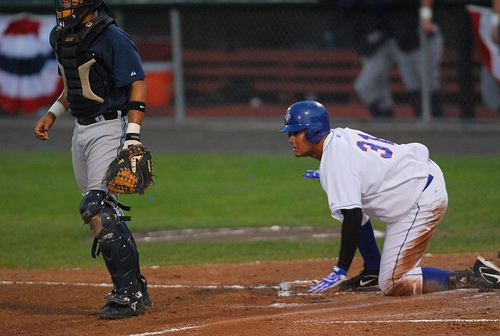

In [70]:
# get all images containing given categories, select one at random
# catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
# imgIds = coco.getImgIds(catIds=catIds );
img_id_to_load = int(flattened_img_ids[np.random.randint(0, len(flattened_img_ids))])
print (img_id_to_load)
img = coco.loadImgs(img_id_to_load)[0]

# load and display image
image_to_disp = io.imread('%s/images/%s/%s'%('../coco/',dataType, img['file_name']))
# use url to load image
# image_to_disp = io.imread('http://mscoco.org/images/%d'%(img['id']))
Image.fromarray(image_to_disp)

## image retrieval code

In [266]:
# def get_random_image(dataset, setting='indoor', obj_categories=None):
#         if dataset == 'ade':
#             return get_ade_image(setting, obj_categories)
#         elif dataset == 'coco':
#             return get_coco_image(setting, obj_categories, coco)
#         elif dataset == 'pascal':
#             return get_pascal_image(setting, obj_categories)

def get_pascal_image(image_df, setting=None, obj_categories=None):
    if setting:
        image_df = image_df[image_df['setting'] == setting]
    img_row_to_load = np.random.randint(0, image_df.shape[0])
    print(image_df.iloc[img_row_to_load]['filename'])
    image_path = os.path.join(voc_img_dir, image_df.iloc[img_row_to_load]['filename'])
    img_to_disp = Image.open(image_path)
    return img_to_disp

def get_coco_image(coco, flattened_img_ids, setting=None, obj_categories=None):
    img_id_to_load = int(flattened_img_ids[np.random.randint(0, len(flattened_img_ids))])
#     print (img_id_to_load)
    img = coco.loadImgs(img_id_to_load)[0]
    image_to_disp = io.imread('%s/images/%s/%s'%('../coco/',dataType, img['file_name']))
    return Image.fromarray(image_to_disp)

def get_ade_image(image_df, ade_pre = '../ade20k/', setting=None, obj_categories=None):
    if setting:
        image_df = image_df[image_df['setting'] == setting]
    img_row_to_load = np.random.randint(0, image_df.shape[0])
    image_path = os.path.join(ade_pre, image_df.iloc[img_row_to_load]['folder'], image_df.iloc[img_row_to_load]['filename'])
    img_to_disp = Image.open(image_path)
    return img_to_disp

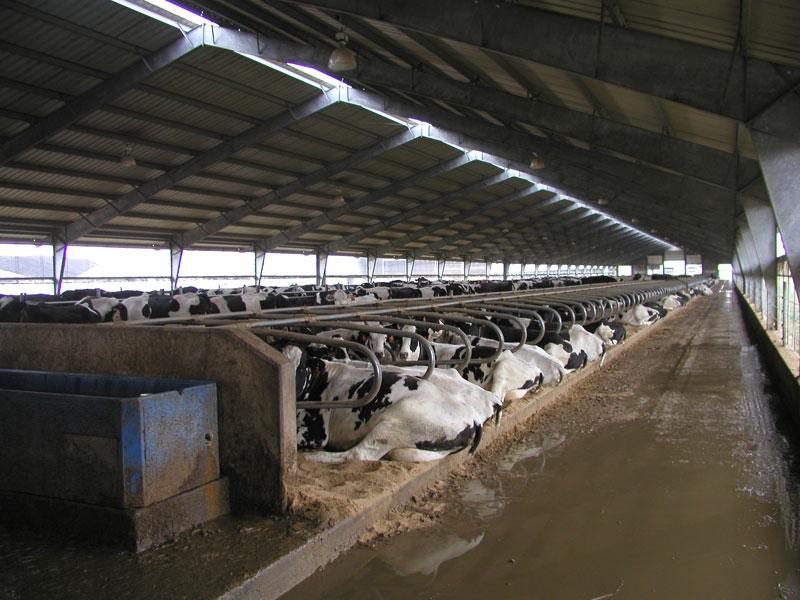

In [272]:
# get_coco_image(coco, flattened_img_ids)
get_ade_image(ade_df.copy(), setting='indoor')

In [365]:
get_pascal_image(pascal_df, 'indoors')

ValueError: low >= high

In [240]:
full_img_annos['2010_001869.jpg']['annotation']['object']

OrderedDict([(u'name', u'dog'),
             (u'bndbox',
              OrderedDict([(u'xmax', u'421'),
                           (u'xmin', u'167'),
                           (u'ymax', u'271'),
                           (u'ymin', u'39')])),
             (u'difficult', u'0'),
             (u'occluded', u'0'),
             (u'pose', u'Left'),
             (u'truncated', u'0')])

In [219]:
pascal_df.iloc[2215]

filename    2008_002955.jpg
setting            outdoors
Name: 2215, dtype: object

# Response of objects to forces

## Dynamics

Describes the motion of objects under the influence of forces
Similar to “What Happens When”.

Questions answerable under Newton’s laws of motion

Inertia, momentum, action/reaction, acceleration

## Statics

Describes the stability or equilibrium of objects under the influence of forces.

Vector forces

Moment of a force

Center of mass and moments of inertia

# Spatial relationships between objects within a scene

## Kinematics (geometry of motion)

What are the implications of an object’s motion (differs from dynamics in that we don’t care about what’s causing the motion).

### Trajectories

Point particle motion under constant velocity or acceleration

Predicting where an object’s existing motion will take it in a scene.

### Collisions

If A is moving in direction X, will it hit object B?

## Topology

A qualitative description of the spatial structure of a scene.

Is A inside or outside of B

Are A and B connected or attached 

## Geometry

A quantitative description of the spatial relationships in a scene.

Surface area and volume

Can A fit in B

Can the liquid in A fit in B

Will A cover B

### Metrics

What are the distances between objects in a scene

### Symmetry

How will an object look if it’s rotated about some axis

# Affordances

I feel like these are higher-level reasoning questions that could be answered if you had a good understanding of the above. 

Can we put A on a B?

Can A hold liquids?

Can we pick up A?

Can we sit on A?